# 5-2 DCGAN の損失関数・学習・生成の実装

## DCGAN の損失関数
DCGAN の損失関数は通常のクラス分類と同様に定義できる．（正確には Jensen-Shannon ダイバージェンスの話になるがここでは省略）  
入力される画像データが $x$ のとき，D の出力は $y = D(x)$ だが，出力 は前節で実装した D の出力にシグモイド関数がかかって，値が0から1に変換されているものとする．
正しいラベルは G が生成した偽データをラベル0，教師データをラベル1とすると D の出力が正答かどうかは $y^l(1-y)^{1-l}$ で表される．
$y^l(1-y)^{1-l}$ は正解ラベル $l$ と予測出力 $y$ の値が同じなら1，異なる間違った予測の場合は0になる．
実際には $y$ は0から1の間の値をとり極端に0や1にならないため，$y^l(1-y)^{1-l}$ も0から1の値になる．

この判定がミニバッチのデータ数 M 個分あるため，その同時確率は次で与えられる．
$$
    \prod_{i = 1}^{M} y_i^{l_i}(1-y_i)^{1-l_i}
$$
これの対数を取ると次のようになる．
$$
    \sum_{i = 1}^{M} [l_i log y_i + (1 - l_i) log (1 - y_i)]
$$
D はこの式（対数尤度）が最大となるように学習する．
最大化は実装が難しいので $-1$ を掛けて最小化問題に帰着する．  
この損失関数は torch.nn.BCEWithLogitsLoss() を使用して簡単に実装できる．（BCE は Binary Cross Entropy の略で2値分類の誤差関数）

In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
class Generator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Generator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size * 8),
            nn.ReLU(inplace=True))

        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 8, image_size * 4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace=True))

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace=True))

        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))

        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 注意：白黒画像なので出力チャネルは1つだけ

    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out
    

class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.last = nn.Conv2d(image_size*8, 1, kernel_size=4, stride=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)

        return out

    
G = Generator()
D = Discriminator()

In [3]:
# D の誤差関数のイメージ実装
# maximize log(D(x)) + log(1 - D(G(z)))
# この段階では x が未定義なため動作はエラーになる

# 正解ラベルを作成
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 偽ラベルを作成
label_fake = torch.full((mini_batch_size,), 0)

# 誤差関数を定義
criterion = nn.BCEWithLogitsLoss(reduction="mean")

# 真の画像を判定
d_out_real = D(x)

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake

NameError: name 'x' is not defined

G は D を騙したいので G で生成した画像に対して D の判定が失敗方向になれば良い．
つまり D は G から生成された画像を正確に判定するために次式を最小化しようとしている．
$$
    -\sum_{i = 1}^{M} [l_i log y_i + (1 - l_i) log (1 - y_i)]
$$
よって，G の損失関数は次のようになる．
$$
    \sum_{i = 1}^{M} [l_i log y_i + (1 - l_i) log (1 - y_i)]
$$
ここで $l_i$ は偽画像は0なので第1項が消え，さらに $ 1 - l_i = 1, y = D(x)$ で，さらに G は $z_i$ から画像を生成するので，G のミニバッチでの損失関数は次で与えられる．
$$
    \sum_{i = 1}^{M} log\left(1-D(G(z_i))\right)
$$

しかし，上式で与えられる損失関数では学習がうまくいかない．
これは，初期段階の G が生成する画像は教師データと大きくかけ離れているため，未熟な D でもある程度正確な判定ができてしまうため，損失がほとんど0になってしまい学習が進めなくなるためである．  
そこで，$D(G(z_i))$が1と判定されれば良いと考え，DCGAN では G の損失関数を次のように定義する．
$$
    -\sum_{i = 1}^{M} log D(G(z_i))
$$
こうすることで，G がうまく D を騙せれば log の中身は1となり損失関数の値は0となる．
一方で D に見抜かれると log の中身は0から1の値となり損失関数は正の大きな値をとり，学習が進むようになる．

In [4]:
# G の誤差関数のイメージ実装
# maximize log(D(G(z)))
# x が未定義なので動作はエラーになります

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
g_loss = criterion(d_out_fake.view(-1), label_real)

ここで，G の損失の計算に D での判定が入っている点に注目する．
損失をバックプロパゲーションしたとき，まず D を通ってから G に到達する．
もし，D の活性化関数に ReLU 関数を使うと，ReLU への入力が負であった場合に出力が0となってしまい，バックプロパゲーションもそこで止まってしまう．
これでは G の学習が進まないため D の活性化関数に LeakyReLU を使って G まで損失がでんぱするようにしている．

## DataLoader の作成
前章までと同様に DataLoader を作成する．

In [5]:
import PIL.Image as Image
import torch.utils.data as data
import torchvision.transforms as transforms

def make_datapath_list():
    """ 学習・検証の画像データとアノテーションデータへのファイルパスリストを作成する """

    train_img_list = list()  # 画像ファイルパスを格納

    for img_idx in range(200):
        img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


class ImageTransform():
    """画像の前処理クラス"""

    def __init__(self, mean, std):
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.data_transform(img)
    
    
class GAN_Img_Dataset(data.Dataset):
    """画像のDatasetクラス。PyTorchのDatasetクラスを継承"""

    def __init__(self, file_list, transform):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''前処理をした画像のTensor形式のデータを取得'''

        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅]白黒

        # 画像の前処理
        img_transformed = self.transform(img)

        return img_transformed

In [6]:
# 動作確認
train_img_list = make_datapath_list()

# Dataset を作成
mean = (0.5,)
std = (0.5,)
train_dataset = GAN_Img_Dataset(file_list=train_img_list, transform=ImageTransform(mean, std))

# Dataloader を作成
batch_size = 64
train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

batch_iterator = iter(train_dataloader)  # イテレータに変換
images = next(batch_iterator)
print(images.size())

torch.Size([64, 1, 64, 64])


## DCGAN の学習
最初にネットワークの初期化を行う．
ここでは，転置畳み込みと畳み込み層と重みは平均0，標準偏差0.02の正規分布で，バッチノーマライゼーションの重みは平均1，標準偏差0.02の正規分布に従う乱数を使って初期化する．
各バイアス項は0にしておく．  
こうした初期化に数学的な意味はなく，経験的に学習がうまく行くことが多いため，このように初期化している．

In [7]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [8]:
# モデル学習させる関数
import time

def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.0001, 0.0004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:

            # --------------------
            # 1. Discriminatorの学習
            # --------------------
            # ミニバッチがサイズが1だと、バッチノーマライゼーションでエラーになるのでさける
            if imges.size()[0] == 1:
                continue

            # GPUが使えるならGPUにデータを送る
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

    return G, D

In [9]:
# 学習
num_epochs = 200
G_update, D_update = train_model(G, D, dataloader=train_dataloader, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 0/200
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0725 ||Epoch_G_Loss:0.2375
timer:  1.3997 sec.
-------------
Epoch 1/200
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0539 ||Epoch_G_Loss:0.3485
timer:  0.9556 sec.
-------------
Epoch 2/200
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0092 ||Epoch_G_Loss:0.4026
timer:  0.9549 sec.
-------------
Epoch 3/200
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.3048 ||Epoch_G_Loss:0.5481
timer:  0.9554 sec.
-------------
Epoch 4/200
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0453 ||Epoch_G_Loss:0.1836
timer:  0.9657 sec.
-------------
Epoch 5/200
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0082 ||Epoch_G_Loss:0.3570
timer:  0.9600 sec.
-------------
Epoch 6/200
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.3266 ||Epoch_G_Loss:0.5385
timer:  0.9649 sec.
-------------
Epoch 7/200
-------------


-------------
epoch 60 || Epoch_D_Loss:0.1172 ||Epoch_G_Loss:0.1420
timer:  0.9697 sec.
-------------
Epoch 61/200
-------------
（train）
-------------
epoch 61 || Epoch_D_Loss:0.1058 ||Epoch_G_Loss:0.1377
timer:  0.9670 sec.
-------------
Epoch 62/200
-------------
（train）
-------------
epoch 62 || Epoch_D_Loss:0.1083 ||Epoch_G_Loss:0.1684
timer:  0.9677 sec.
-------------
Epoch 63/200
-------------
（train）
-------------
epoch 63 || Epoch_D_Loss:0.0965 ||Epoch_G_Loss:0.1634
timer:  0.9674 sec.
-------------
Epoch 64/200
-------------
（train）
-------------
epoch 64 || Epoch_D_Loss:0.0964 ||Epoch_G_Loss:0.1596
timer:  0.9659 sec.
-------------
Epoch 65/200
-------------
（train）
-------------
epoch 65 || Epoch_D_Loss:0.0939 ||Epoch_G_Loss:0.1835
timer:  0.9667 sec.
-------------
Epoch 66/200
-------------
（train）
-------------
epoch 66 || Epoch_D_Loss:0.0840 ||Epoch_G_Loss:0.1591
timer:  0.9690 sec.
-------------
Epoch 67/200
-------------
（train）
-------------
epoch 67 || Epoch_D_Loss:0.

-------------
epoch 120 || Epoch_D_Loss:0.0644 ||Epoch_G_Loss:0.2394
timer:  0.9714 sec.
-------------
Epoch 121/200
-------------
（train）
-------------
epoch 121 || Epoch_D_Loss:0.0793 ||Epoch_G_Loss:0.2509
timer:  0.9713 sec.
-------------
Epoch 122/200
-------------
（train）
-------------
epoch 122 || Epoch_D_Loss:0.0491 ||Epoch_G_Loss:0.3159
timer:  0.9755 sec.
-------------
Epoch 123/200
-------------
（train）
-------------
epoch 123 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.2410
timer:  0.9703 sec.
-------------
Epoch 124/200
-------------
（train）
-------------
epoch 124 || Epoch_D_Loss:0.0752 ||Epoch_G_Loss:0.2685
timer:  0.9704 sec.
-------------
Epoch 125/200
-------------
（train）
-------------
epoch 125 || Epoch_D_Loss:0.0624 ||Epoch_G_Loss:0.2480
timer:  0.9700 sec.
-------------
Epoch 126/200
-------------
（train）
-------------
epoch 126 || Epoch_D_Loss:0.0675 ||Epoch_G_Loss:0.2767
timer:  0.9709 sec.
-------------
Epoch 127/200
-------------
（train）
-------------
epoch 127 || 

-------------
epoch 179 || Epoch_D_Loss:0.0406 ||Epoch_G_Loss:0.4020
timer:  0.9773 sec.
-------------
Epoch 180/200
-------------
（train）
-------------
epoch 180 || Epoch_D_Loss:0.0443 ||Epoch_G_Loss:0.3521
timer:  0.9726 sec.
-------------
Epoch 181/200
-------------
（train）
-------------
epoch 181 || Epoch_D_Loss:0.0329 ||Epoch_G_Loss:0.4114
timer:  0.9728 sec.
-------------
Epoch 182/200
-------------
（train）
-------------
epoch 182 || Epoch_D_Loss:0.0517 ||Epoch_G_Loss:0.4294
timer:  0.9743 sec.
-------------
Epoch 183/200
-------------
（train）
-------------
epoch 183 || Epoch_D_Loss:0.0238 ||Epoch_G_Loss:0.4084
timer:  0.9728 sec.
-------------
Epoch 184/200
-------------
（train）
-------------
epoch 184 || Epoch_D_Loss:0.0334 ||Epoch_G_Loss:0.4544
timer:  0.9788 sec.
-------------
Epoch 185/200
-------------
（train）
-------------
epoch 185 || Epoch_D_Loss:0.0253 ||Epoch_G_Loss:0.5242
timer:  0.9784 sec.
-------------
Epoch 186/200
-------------
（train）
-------------
epoch 186 || 

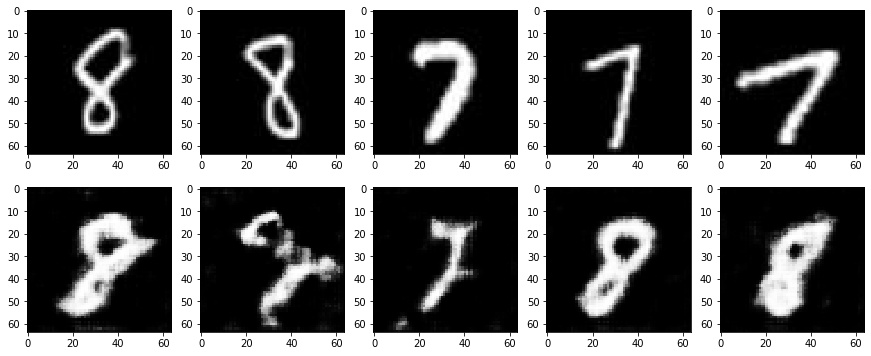

In [11]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(train_dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

上段が訓練データ，下段が DCGAN により生成した画像である．
DCGAN により手書き数字の画像と思えるものが生成されていることが確認できる．
今回は時間短縮のため数字の教師画像を7と8をそれぞれ200枚しか用意しておらず、学習のepoch 数をこれ以上増やすと、生成器 G は数字の7の画像しか生成しなくなる．
これは数字の7の方が画像的に8に比べると単純で，識別器 D を騙す画像を生成しやすいため，生成器 G が7ばかり生成してしまう。
このような教師データの一部しか生成しなくなる現象をモード崩壊と呼ぶ．